In [2]:
from os.path import join
import datetime
from dateutil.relativedelta import relativedelta
from copy import deepcopy

import matplotlib.pyplot as plt
plt.style.use('bmh') 
import numpy as np
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation
import cf_units
import cftime

import warnings
warnings.filterwarnings('ignore')

In [3]:
def read_cmip6_hist_conc(hist_conc_file):
    """
    Read in a CMIP6 historical concentration file using iris.
    
    We require this custom function as the CMIP6 historical
    concentration files were released using a 'gregorian' 
    calendar with a unit of 'days since 0-1-1'. As year 0
    does not exist in a gregorian calendar, this time axis
    can't actually be used by iris. Hence we provide a 
    function to read them in using iris here.
    
    Please note: this function cuts out years 0 and 1 of the 
    data. We cut out year 0 as this year does not exist in a 
    gregorian calendar. We cut out year 1 as we can't have a
    year of 0 in a datetime object and we need our reference
    time to be 'days since 1-1-1' in the end.
    
    # Parameters
    hist_conc_file (str): full path to the file containing
        CMIP6 historical concentrations
        
    # Returns
    hist_conc_cube (iris.cube.Cube): iris Cube containing the
        concentrations data as in the original file. To make
        the data iris compatible, we remove year 0 (i.e. the
        first year of data)
    """
    original_cube = iris.load_cube(hist_conc_file)
    tcoord_idx = 0
    original_tcoord = original_cube.coords()[tcoord_idx]
    scoord_idx = 1

    assert_msg = (
        "This function is only setup to work with files "
        "which have time as the first coordinate"
    )
    assert original_tcoord.standard_name == "time", assert_msg

    assert_msg = (
        "This function is only setup to work with files "
        "which have an input unit name of days since 1-1-1"
    )
    assert str(original_tcoord.units.name) == 'day since 1-01-01 00:00:00.000000 UTC', assert_msg

    assert_msg = (
        "This function is only setup to work with files "
        "which have sector as the second coordinate"
    )
    assert original_cube.coords()[scoord_idx].var_name == "sector", assert_msg

    assert_msg = (
        "This function is only setup to work with files "
        "which have two coordinates: time and sector"
    )
    assert len(original_cube.coords()) == 2, assert_msg

    print(original_tcoord.units.calendar)
    tmp_time = cftime.num2date(
        original_tcoord.points, 
        original_tcoord.units.name, 
        original_tcoord.units.calendar,
    )
    tmp_time = np.array([datetime.datetime(*v.timetuple()[:6]) for v in tmp_time])

    # Find the years we can actually use
    #     Note that the dates are automatically shifted a year
    #     by netCDF4.num2date so we have to find years after 
    #     year 3, not year 2
    automatic_shift = 1
    years_to_bin = 2
    first_valid_year = automatic_shift + years_to_bin
    valid_data = tmp_time > datetime.datetime(first_valid_year, 1, 1)

    # get time axis we can use
    tmp_time = tmp_time[valid_data]
    # undo the automatic shift of year and then also take off
    # one more year to that we match our new_units
    tmp_time = tmp_time - relativedelta(years=automatic_shift)
    # put time back into an array so we can use with DimCoord
    new_time = cf_units.date2num(
        tmp_time, 
        original_tcoord.units.name, 
        original_tcoord.units.calendar
    )
    new_time_unit = cf_units.Unit(
        original_tcoord.units.name, 
        calendar=original_tcoord.units.calendar
    )
    new_tcoord = iris.coords.DimCoord(
        new_time,
        standard_name=original_tcoord.standard_name, 
        long_name=original_tcoord.long_name, 
        var_name=original_tcoord.var_name,
        units=new_time_unit,
    )
    original_data = original_cube.data
    new_data = original_data[valid_data, :]
    hist_conc_cube = iris.cube.Cube(new_data)
    hist_conc_cube.add_dim_coord(new_tcoord, tcoord_idx)
    hist_conc_cube.add_dim_coord(
        original_cube.coords()[scoord_idx], 
        scoord_idx
    )
    attributes_to_copy = [
        "attributes",
        "cell_methods",
        "units",
        "var_name",
        "standard_name",
        "name",
        "metadata",
        "long_name",
    ]
    for att in attributes_to_copy:
        setattr(hist_conc_cube, att, getattr(original_cube, att))

    return hist_conc_cube

In [8]:
DATA_PATH_SCENARIOS = "/Users/zebedeenicholls/Documents/AGCEC/Data/CMIP6GHGConcentrationProjections_1_2_0/"
BASE_NAME_SCENARIOS = "mole-fraction-of-gas-in-air_input4MIPs_GHGConcentrations_scenario-1-2-0_gr1-GMNHSH_201501-250012.nc"

DATA_PATH_HISTORICAL = "/Users/zebedeenicholls/Documents/AGCEC/Data/CMIP6GHGConcentrationHistorical_1_2_0/"
BASE_NAME_HISTORICAL = "mole-fraction-of-gas-in-air_input4MIPs_GHGConcentrations_scenario-1-2-0_gr1-GMNHSH_000001-201412.nc"

SCENARIOS = [
    ["ScenarioMIP_UoM-REMIND-MAGPIE-ssp585", "pink", "-"],
    ["ScenarioMIP_UoM-REMIND-MAGPIE-ssp534-over", "pink", "--"],
    ["ScenarioMIP_UoM-GCAM4-ssp460", "darkorange", "-"],
    ["ScenarioMIP_UoM-GCAM4-ssp434", "gold", "-"],
    ["ScenarioMIP_UoM-AIM-ssp370", "red", "-"],
    ["AerChemMIP_UoM-AIM-ssp370-lowNTCF", "red", "--"],
    ["ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245", "blue", "-"],
    ["ScenarioMIP_UoM-IMAGE-ssp126", "lightgreen", "-"],
    ["ScenarioMIP_UoM-IMAGE-ssp119", "darkgreen", "-"],
    ["CMIP_UoM-CMIP", "black", "-"]
]

GASES_TO_PLOT = [
#     "nitrous-oxide",
    "so2f2",
#     "methane",
]

In [20]:
import iris
iris.load_cube?

In [5]:
def adjust_cube_calendar(cube_in, target_calendar='gregorian'):
    cube_adjusted = cube_in.copy()
    
    for i, coord in enumerate(cube_adjusted.coords()):
        if coord.standard_name == "time":
            tcoord_idx = i
            break
            
    try:
        tcoord_idx
    except NameError:
        error_msg = (
            "Did not find a co-ordinate with "
            "standard_name == 'time' in the "
            "input cube"
        )
        raise ValueError(error_msg)
        
    tcoord = cube_adjusted.coord('time')
    tcoord.units = cf_units.Unit(
        tcoord.units.origin, 
        calendar=target_calendar
    )

    return cube_adjusted

In [6]:
hcube = read_cmip6_hist_conc(join(
    DATA_PATH_HISTORICAL, 
    "mole-fraction-of-so2f2-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc"
))
print(hcube.coords('time')[0])
hcube.coords('time')[0]

gregorian
DimCoord([0002-07-03 12:00:00, 0003-07-02 12:00:00, 0004-07-03 00:00:00, ...,
       2012-07-03 00:00:00, 2013-07-03 12:00:00, 2014-07-03 12:00:00], standard_name='time', calendar='gregorian', long_name='time', var_name='time')


DimCoord(array([5.485000e+02, 9.125000e+02, 1.279000e+03, ..., 7.346880e+05,
       7.350535e+05, 7.354185e+05]), standard_name='time', units=Unit('day since 1-01-01 00:00:00.000000', calendar='gregorian'), long_name='time', var_name='time')

In [18]:
obs_time = hcube.dim_coords[0]
obs_time.units.name
obs_time.units.calendar

'gregorian'

In [19]:
obs_time = hcube.dim_coords[0]
obs_time = cf_units.num2date(
            obs_time.points, obs_time.units.name, obs_time.units.calendar
        )
obs_time[-1]

datetime.datetime(2014, 7, 3, 12, 0)

In [7]:
hcube_adjusted = adjust_cube_calendar(hcube, target_calendar="365_day")
print(hcube_adjusted.coords('time')[0])
hcube_adjusted.coords('time')[0]

DimCoord([0002-07-03 12:00:00, 0003-07-02 12:00:00, 0004-07-04 00:00:00, ...,
       2013-11-05 00:00:00, 2014-11-05 12:00:00, 2015-11-05 12:00:00], standard_name='time', calendar='365_day', long_name='time', var_name='time')


DimCoord(array([5.485000e+02, 9.125000e+02, 1.279000e+03, ..., 7.346880e+05,
       7.350535e+05, 7.354185e+05]), standard_name='time', units=Unit('day since 1-01-01 00:00:00.000000', calendar='365_day'), long_name='time', var_name='time')

gregorian


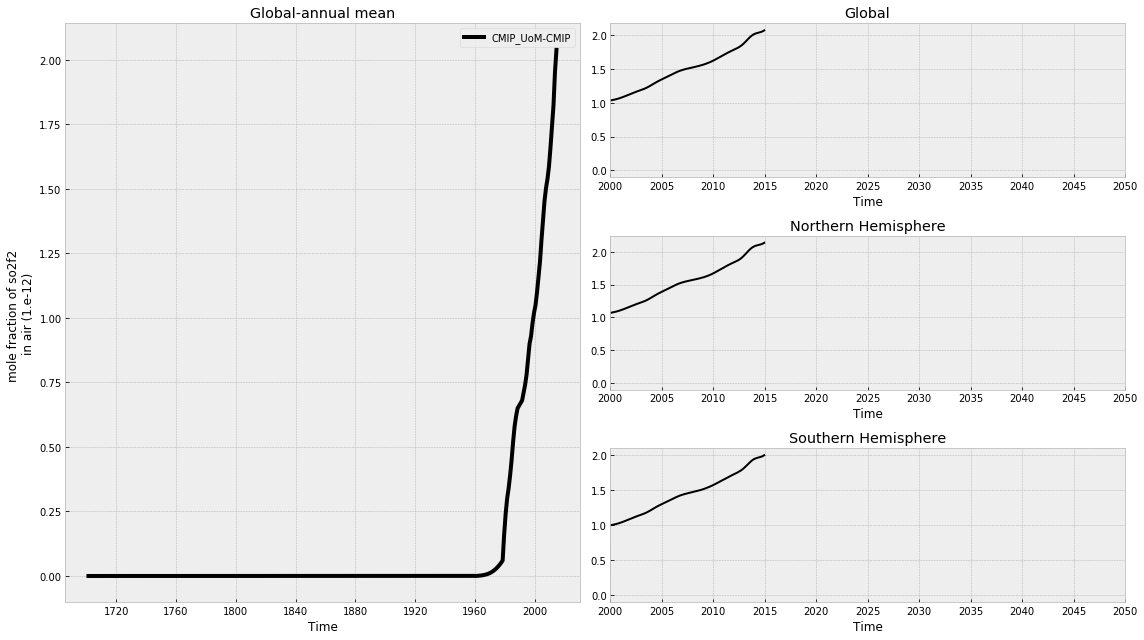

In [13]:
for gas in GASES_TO_PLOT:
    fig = plt.figure(figsize=(16, 9))
    for scenario, colour, style in SCENARIOS:
        if "CMIP_UoM-CMIP" in scenario:
            data_path = DATA_PATH_HISTORICAL
            base_name = BASE_NAME_HISTORICAL
        else:
            data_path = DATA_PATH_SCENARIOS
            base_name = BASE_NAME_SCENARIOS
            
        fn = join(
            data_path,
            base_name.replace("gas", gas).replace("scenario", scenario)
        )
        
        if "CMIP_UoM-CMIP" in scenario:
            cube = read_cmip6_hist_conc(fn)
        else:
            continue
        
        cube = adjust_cube_calendar(cube)
        yearmin = 1700
        cube = cube.extract(
            iris.Constraint(time=lambda t: t[0].year > yearmin)
        )
        
        for i in range(3):
            region = cube.extract(
                iris.Constraint(sector=i)
            )
            for title in region.coord('sector').attributes['ids'].split(";"):
                if title.strip().startswith(str(i)):
                    title = title.split(":")[1].strip()
                    break
            
            if "Global" in title:
                plt.subplot(322)
            elif "Northern" in title:
                plt.subplot(324)
            elif "Southern" in title:
                plt.subplot(326)
            
            iplt.plot(
                region, 
                label=scenario,
                color=colour,
                ls=style,
                lw=2.0
            )
            xlabel = "Time"
            plt.title(title)
            plt.xlabel(xlabel)
            plt.xlim([
                datetime.date(2000, 1, 1), 
                datetime.date(2050, 1, 1),
            ])
            if "dioxide" in gas:
                plt.ylim([360, 600])
            elif "methane" in gas:
                plt.ylim([1220, 2600])
            elif "nitrous" in gas:
                plt.ylim([310, 370])

            if "Global" in title:                
                plt.subplot(121)
                
                iris.coord_categorisation.add_year(
                    region,
                    'time', 
                    name='year'
                ) 
                region_annual_mean = region.aggregated_by(
                    ['year'],
                    iris.analysis.MEAN
                )

                iplt.plot(
                    region_annual_mean, 
                    label=scenario,
                    color=colour,
                    ls=style,
                    lw=4.0
                )
                
                plt.legend()
                var_name = region.var_name.replace("_", " ")
                var_name = var_name.replace("in", "\nin")
                plt.ylabel("{} ({})".format(var_name, region.units))
                plt.title(title + "-annual mean")
                plt.xlabel("Time")
            
    plt.tight_layout();
#     plt.savefig("{}-CRESCENDO-2018.pdf".format(gas), transparent=True)